# Filter papers by software

In [24]:
# load utilities shared between notebooks
%run definitions_and_functions.ipynb

There are millions of references to papers in the zbMath database. We just need (for now) those related to the list of mathematical software (data/swMATH-software-list.csv) that has been imported into the MaRDI-Portal.

In [2]:
import pandas as pd

# load the list of swMath software
software_df = pd.read_csv('data/swMATH-software-list.csv')
softwares = software_df['Len'].tolist()

**I'm looking at these attributes for each paper, please double check if that's OK, since importing everything will take hours.**

In [49]:
print('zbMath paper id and', TAGS)

zbMath paper id and ['author', 'author_ids', 'document_title', 'source', 'classifications', 'keywords', 'doi', 'publication_year']


## Get a list of records related to a single software
Use the helper/filter endpoint to get a list of papers related to a particular software. In this case 'Gfan'.

**Doesn't work for some software (e.g. FORTRAN) mailed OAI suport about this**

In [3]:
import requests

software = 'Gfan'
REQUEST_URL="{}&filter=software:{}".format(FILTER, software)

# get data from API
headers = {'accept': 'text/xml'} # this has no effect
all_records_xml = requests.get(REQUEST_URL, headers)
if all_records_xml.status_code == 200:
    # save raw data in local file
    with open('data/software_records_{}.xml'.format(software), 'w') as f:
        f.write(all_records_xml.text)    
else: 
    print(all_records_xml.reason)

Define a function to parse all records in the data set, put them into a pandas data frame

In [4]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_record_list(records, verbose=False):
    """
    Parses a list of 'record' XML elements.
    @return pandas DataFrame or None (if no suitably licensed data was found)
    """
    # loop through all entries
    all_details = []
    for record in records:
        details = parse_record(record)
        if details:
            all_details.append(details)

    # convert to data frame
    records_df = pd.DataFrame(all_details)
    if 'id' not in records_df.columns:
        if verbose: print("Problem reading zbMath id's. No data suitably licensed data?")
        return None
    else:
        records_df.set_index('id', inplace=True)
        if verbose:
            print('Imported {} entries (discarded {} for licensing conflicts)'.format(len(records_df), len(records) - len(records_df) ))
        
    return records_df

## Get records for the first 1000 software entries
Go through the list of software, get the records from the zbMath Open API, put them in a data frame.

Only process the first 1000 entries, as there are +- 40000 software entries in the list (processing the first 1000 entries took 5:34, so total would be +- 3h 40 min).

If there's an API error, log and continue.

In [25]:
import requests
from xml.etree.ElementTree import ParseError

MAX_ENTRIES = 1000 # number of entries to process
all_details = pd.DataFrame() # the final data frame
counter = 0
for software in softwares[:MAX_ENTRIES]:
    headers = {'accept': 'text/xml'} # this has no effect
    REQUEST_URL="{}&filter=software:{}".format(FILTER, software)
    
    try:
        # get data from API
        all_records_xml = requests.get(REQUEST_URL, headers)
        if all_records_xml.status_code == 500: raise ZbMathOpenAPIException(all_records_xml.reason)
        
        #parse the tree, get a list of records
        tree = ET.fromstring(all_records_xml.text)
        list_ids = tree.find(ns('ListRecords')) # when parsing XML from string, don't call getroot()
        records = list_ids.findall(ns('record'))
        # parse record details into a data frame
        records_df = parse_record_list(records)
        
        # add name of software and append new records to final data frame        
        if records_df is not None:
            records_df['software'] = software
            all_details = all_details.append(records_df)
            # log success
            log('Processing {}: Imported {} entries (discarded {} for licensing conflicts)'.format(software, len(records_df), len(records) - len(records_df) ))
        else:
            # no suitable records found
            log("[WARNING] Processing {}: Problem reading zbMath id's. No data suitably licensed data?".format(software))
            
        # print progress feedback
        counter += 1
        if counter % 100 == 0: print("processed {}/{} entries".format(counter, MAX_ENTRIES))
            
    except ZbMathOpenAPIException as e:
        # if the API throws a server-side error, log and continue
        log("[ERROR] While reading filter=software:{} from zbMath Open API help/filter endpoint: {}".format(software, e))
    except ParseError as e:
        # if the API returns wrong XML, log and continue
        log("[ERROR] While reading filter=software:{} from zbMath Open API help/filter endpoint: {}".format(software, e))

print("Done. Check {} for errors".format(IMPORT_LOG))

processed 100/1000 entries
processed 200/1000 entries
processed 300/1000 entries
processed 400/1000 entries
processed 500/1000 entries
processed 600/1000 entries
processed 700/1000 entries
processed 800/1000 entries
processed 900/1000 entries
Done. Check data/api.log for errors


Save data in compressed file for later use

In [65]:
all_details.to_csv('data/all_records.csv.zip', compression=dict(method='zip', archive_name='all_records.csv'))

### Cleanup
Drop incomplete entries: no author or no author ids or no title

In [39]:
import pandas as pd

# re-read the data from file
all_details = pd.read_csv('data/software_all_records.csv.zip')
print("Read data frame from file: rows {}, columns {}".format(all_details.shape[0], all_details.shape[1]))

# drop entries without an author or a title
idx = (all_details.author.isna()) | all_details.author_ids.isna() | (all_details.document_title.isna())
all_details = all_details[~idx]
print('{} incomplete entries were removed'.format(idx.sum()))

Read data frame from file: rows 11577, columns 10
981 incomplete entries were removed


## Consolidate data
Prepare data for import into wikibase.

### A data frame with all the papers
Drop duplicates: same doi, same combination of authors-title-year

In [125]:
all_papers = all_details
idx = (all_papers.duplicated(subset='doi')) | (all_papers.duplicated(subset=['author', 'document_title', 'publication_year']))
all_papers = all_papers[~idx]
print('Found {} papers. {} duplicated entries were removed'.format(len(all_papers), idx.sum()))
# index by zbMath paper id
all_papers.set_index('id', inplace=True) 
all_papers.to_csv('data/all_papers.csv.zip', compression=dict(method='zip', archive_name='all_papers.csv'))

Found 9193 papers. 1403 duplicated entries were removed


### A data frame with all the authors and author_ids
All authors should be listed in a separate data frame to facilitate import into wikibase.

In [126]:
authors_df = pd.DataFrame(columns=['author_id', 'author_name'])
for _,row in all_papers.iterrows():
    author_ids = row.author_ids.split(';')
    author_names = row.author.split(';')
    for i in range(min(len(author_ids), len(author_names))):
        authors_df = authors_df.append({'author_id': author_ids[i], 'author_name': author_names[i]}, ignore_index=True)

# remove duplicates
idx = authors_df.duplicated()
authors_df = authors_df[~idx]
authors_df = authors_df.set_index('author_id').sort_index()
print('Found {} authors'.format(len(authors_df)))

Found 17985 authors


In [127]:
authors_df.to_csv('data/all_authors.csv.zip', compression=dict(method='zip', archive_name='all_authors.csv'))

### A data frame with all the paper-to-software relations

In [128]:
diff = all_papers.columns.difference(['id', 'software'])
all_papers_software = all_papers.drop(columns=diff)
print("Found {} paper-to-software relations".format(len(all_papers_software)))

Found 9193 paper-to-software relations


In [129]:
all_papers_software.to_csv('data/all_papers_software.csv.zip', compression=dict(method='zip', archive_name='all_papers_software.csv'))

# Hey why not take a closer look at this cool data set :-)
The data set is incomplete, since I've so far processed 1000 software tags, and many give errors.

## What are the most popular math softwares?

In [157]:
paper_counts_by_software = all_papers_software.groupby('software').size().reset_index(name='paper count').sort_values(by='paper count', ascending=False)
paper_counts_by_software.head(10) # top 10

,software,paper count
268,Hyperheuristics,87
65,CASA,82
35,BARON,75
467,PSPLIB,75
154,Expokit,71
692,mclust,71
116,DEA,66
284,ISOGAT,66
96,Cadabra,65
435,PALP,65


## Has software usage changed over time?

In [273]:
from collections import Counter

# just looking at the top 5 software
top_software = paper_counts_by_software[:5]
# dict software name -> count publication by year
top_software_years = {} 
for _, row in top_software.iterrows():
    software_name = row['software']
    # all papers that use this software
    idx = all_papers_software['software'] == software_name
    papers_software = all_papers_software[idx]
    # publication years (including duplicated values)
    years = all_papers.loc[papers_software.index, 'publication_year'].values
    top_software_years[software_name]= dict(Counter(years))

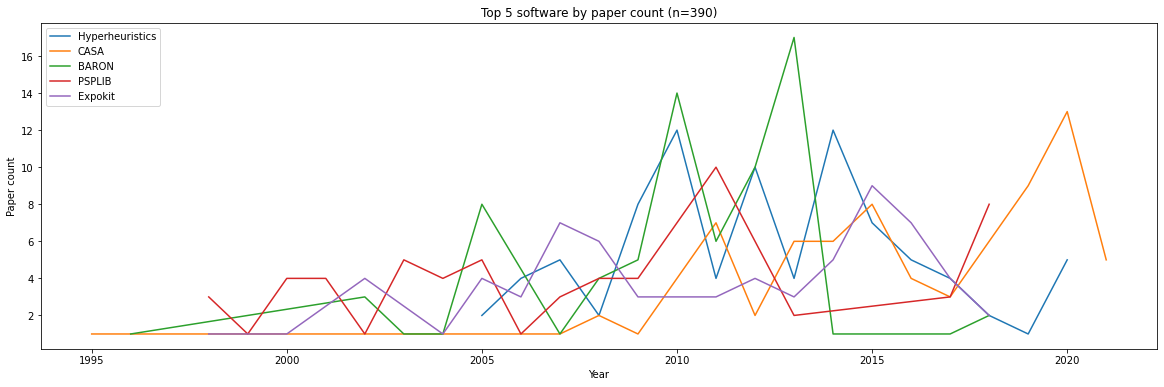

In [311]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 6))
for label, years in top_software_years.items():
    keys = sorted(years)
    vals = [years[key] for key in keys]
    plt.plot(keys, vals, label=label)
plt.legend(loc='upper left')
plt.title('Top 5 software by paper count (n={})'.format(top_software['paper count'].sum()))
plt.xlabel('Year')
plt.ylabel('Paper count')
plt.show()